In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

# Non-parametric Measures of Periodicity – Return of the Gaps

**Version 0.1**

* * *

By AA Miller (Northwester/CIERA)  
16 Sep 2021

In this lecture we will examine non-parametric methods to search for periodic signals in astronomical time series. Earlier this session, we focused extensively the Lomb-Scargle periodogram. LS is the "standard" in astronomy, in part because it was the first (good) method developed for noisy and sparse data.

LS is not without warts, however, (i) LS does not handle outliers well, and (ii) LS works best on purely sinusoidal signals.

Given non-Gaussian noise and that some signals (e.g., transiting planet) are not sinusoidal, we will now explore alternative methods to search for periodicity.

## Problem 1) Helper Functions

We need re-use our lectures from Lecture III.

**Problem 1a**

Create a function, `gen_periodic_data`, that creates simulated data (including noise) over a grid of user supplied positions:

$$ y = A\,cos\left(\frac{x}{P} - \phi\right) + \sigma_y$$

where $A, P, \phi$ are inputs to the function. `gen_periodic_data` should include Gaussian noise, $\sigma_y$, for each output $y_i$.

In [2]:
def gen_periodic_data(x, period=1, amplitude=1, phase=0, noise=0):
    '''Generate periodic data given the function inputs
    
    y = A*cos(x/p - phase) + noise
    
    Parameters
    ----------
    x : array-like
        input values to evaluate the array
    
    period : float (default=1)
        period of the periodic signal
    
    amplitude : float (default=1)
        amplitude of the periodic signal
    
    phase : float (default=0)
        phase offset of the periodic signal
    
    noise : float (default=0)
        variance of the noise term added to the periodic signal
    
    Returns
    -------
    y : array-like
        Periodic signal evaluated at all points x
    '''
    
    y = amplitude*np.sin(2*np.pi*x/(period) - phase) + np.random.normal(0, np.sqrt(noise), size=len(x))
    return y

**Problem 1b**

Create a function, `phase_plot`, that takes x, y, and $P$ as inputs to create a phase-folded light curve (i.e., plot the data at their respective phase values given the period $P$).

Include an optional argument, `y_unc`, to include uncertainties on the `y` values, when available.

In [3]:
def phase_plot(x, y, period, y_unc = 0.0):
    '''Create phase-folded plot of input data x, y
    
    Parameters
    ----------
    x : array-like
        data values along abscissa

    y : array-like
        data values along ordinate

    period : float
        period to fold the data
        
    y_unc : array-like
        uncertainty of the 
    '''    
    phases = (x/period) % 1
    if type(y_unc) == float:
        y_unc = np.zeros_like(x)
        
    plot_order = np.argsort(phases)
    fig, ax = plt.subplots()
    ax.errorbar(phases[plot_order], y[plot_order], y_unc[plot_order],
                 fmt='o', mec="0.2", mew=0.1)
    ax.set_xlabel("phase")
    ax.set_ylabel("signal")
    fig.tight_layout()

## Problem 2) String Length

The string length method ([Dworetsky](http://adsabs.harvard.edu/abs/1983MNRAS.203..917D)), phase folds the data at trial periods and then minimizes the distance to connect the phase-ordered observations.

<img style="display: block; margin-left: auto; margin-right: auto" src="./images/StringLength.png" align="middle">

<div align="right"> <font size="-3">(credit: Gaveen Freer - http://slideplayer.com/slide/4212629/#) </font></div>

**Problem 2a**

Simulate a light curve with 47 observations over a duration of 61 d, $P = 0.7\,\mathrm{d}$, $A = 2$, and variance of the noise 0.01.

<IPython.core.display.Javascript object>


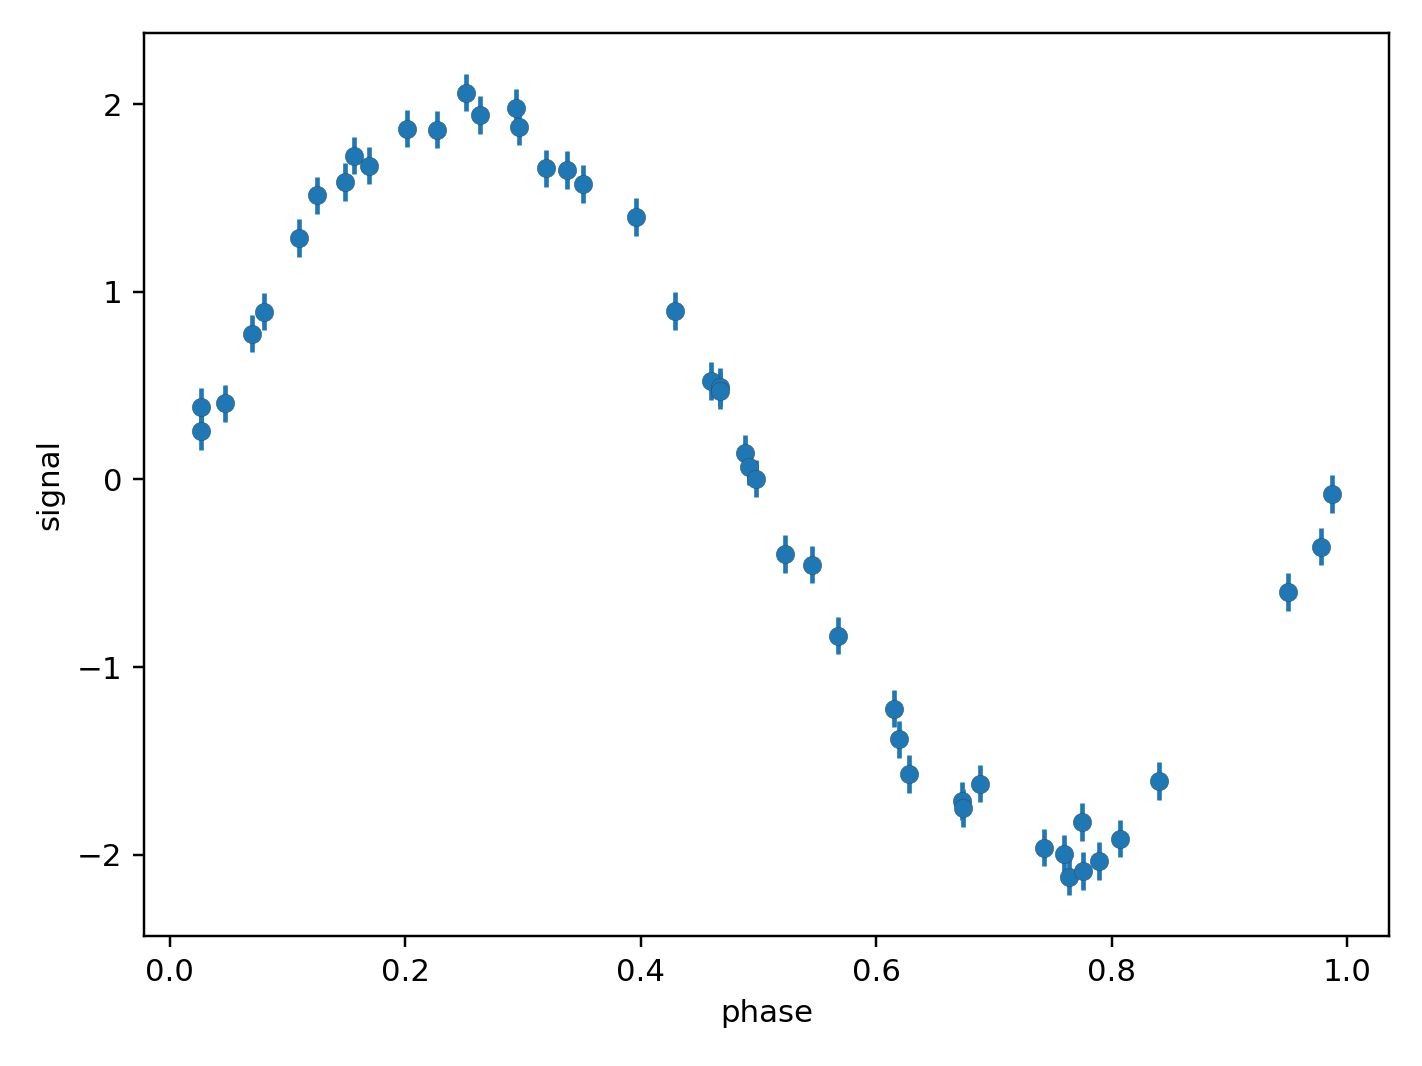

In [4]:
t_obs = np.random.uniform(0,61,size=47)
y = gen_periodic_data(t_obs, period=0.7, amplitude=2, phase=0, noise=0.01)

phase_plot(t_obs, y, 0.7, y_unc = 0.1*np.ones_like(y))

**Probelm 2b**

Write a function, `calc_string_length`, that calculates the string length for a phase-folded light curve with observations `x`, `y`, and frequency `f`.

In [5]:
def calc_string_length(x, y, f=1):
    '''Calculate string length for observations at frequency f
    
    Parameters
    ----------
    x : array-like
        input time of observations
    
    y : array-like
        measured signal at input x
    
    f : float (default=1)
        frequency of the test period
        
    Returns
    -------
    sl : float
        String length for the phase-ordered observations
    
    '''
    
    phases = x*f % 1
    sl = np.sum(np.hypot(np.diff(np.sort(phases)), np.diff(y[np.argsort(phases)])))
    return sl

**Problem 2c** 

Write a function `sl_periodogram` to measure the string length for input data 'x', 'y', over a frequency grid `f_grid'.

In [6]:
def sl_periodogram(x, y, f_grid = np.linspace(0.1,10,10)):
    '''Calculate the string length "periodogram"
    
    Parameters
    ----------
    x : array-like
        input time of observations
    
    y : array-like
        measured signal at input x
    
    f_grid : array_like (default=np.linspace(0.1,10,10))
        frequency grid for the period
        
    Returns
    -------
    sl_psd : array_like
        String length at every test frequency f
    
    '''
    
    sl_psd = np.zeros_like(f_grid)
    for f_num, f in enumerate(f_grid):
        sl_psd[f_num] = calc_string_length(x,y,f)
    
    return sl_psd

**Problem 2d**

Plot the string length periodogram for the simulated data. Does it make sense?

*Hint - think about the optimal grid from Notebook III*

<IPython.core.display.Javascript object>


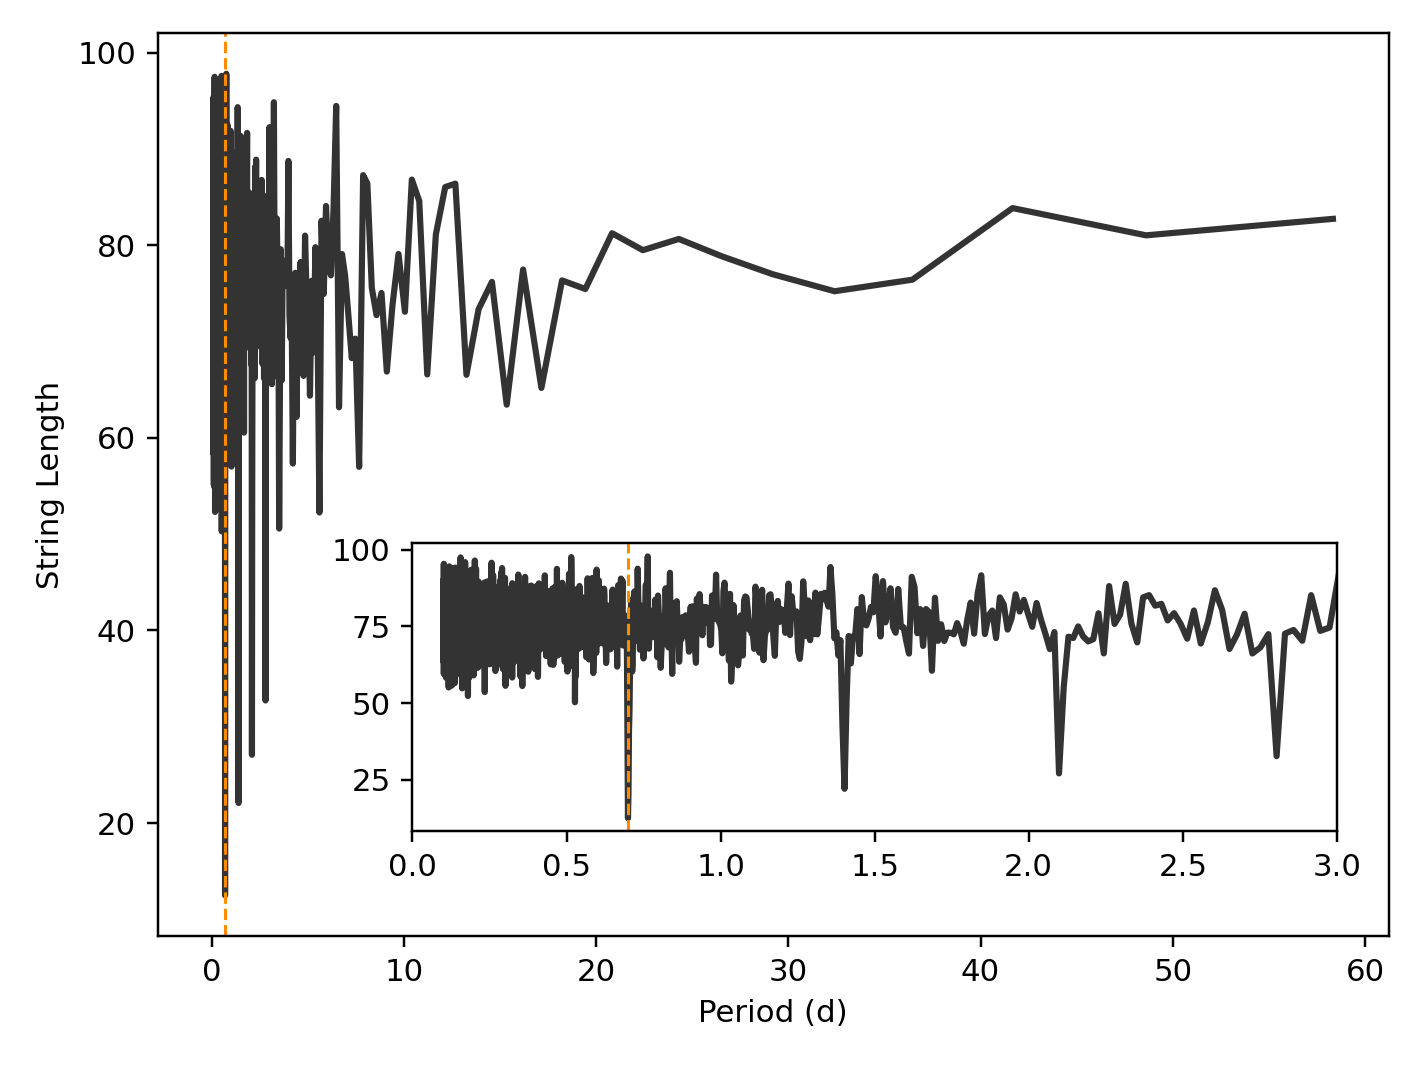

/Users/adamamiller/miniconda3/envs/DSFP/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [11]:
f_grid = np.arange(1/np.ptp(t_obs), 10, 1/5/np.ptp(t_obs))
sl_psd = sl_periodogram(t_obs, y, f_grid)

fig, ax = plt.subplots()
ax.plot(1/f_grid, sl_psd, '0.2', lw=2)
ax.set_xlabel('Period (d)')
ax.set_ylabel('String Length')

ax.axline((0.7,np.mean(sl_psd)), (0.7, np.mean(sl_psd)+1e-3), 
          color='DarkOrange',  lw=1, ls='--')

axins = plt.axes([.29, .22, .65, .27])
axins.plot(1/f_grid, sl_psd, '0.2', lw=2)
axins.axline((0.7,np.mean(sl_psd)), (0.7, np.mean(sl_psd)+1e-3), 
          color='DarkOrange',  lw=1, ls='--')
axins.set_xlim(0,3)

fig.tight_layout()

## Problem 3) Phase Dispersion Minimization

In [8]:
def calc_pdm(x, y, f=1, bins=10):
    '''Calculate the phase dispersion minimization for observations at frequency f
    
    Parameters
    ----------
    x : array-like
        input time of observations
    
    y : array-like
        measured signal at input x
    
    f : float (default=1)
        frequency of the test period
    
    bins : int (default=10)
        
    Returns
    -------
    pdm : float
        the sum of the scatter in each bin
    
    '''
    
    phases = x*f % 1
    pdm = 0
    for bin_num in range(10):
        this_bin = np.where((phases >= bin_num/10) & 
                            (phases < (bin_num+1)/10))
        if len(this_bin[0]) > 1:
            pdm += np.std(y[this_bin], ddof=1)/bins
    return pdm

In [9]:
def pdm_periodogram(x, y, f_grid = np.linspace(0.1,10,10), **kwargs):
    '''Calculate the phase dispersion minimization "periodogram"
    
    Parameters
    ----------
    x : array-like
        input time of observations
    
    y : array-like
        measured signal at input x
    
    f_grid : array_like (default=np.linspace(0.1,10,10))
        frequency grid for the period
        
    Returns
    -------
    pdm_psd : array_like
        PDM at every test frequency f
    
    '''
    
    pdm_psd = np.zeros_like(f_grid)
    total_rms = np.std(y, ddof=1)
    for f_num, f in enumerate(f_grid):
        pdm_psd[f_num] = calc_pdm(x,y,f)/total_rms
    
    return pdm_psd

<IPython.core.display.Javascript object>


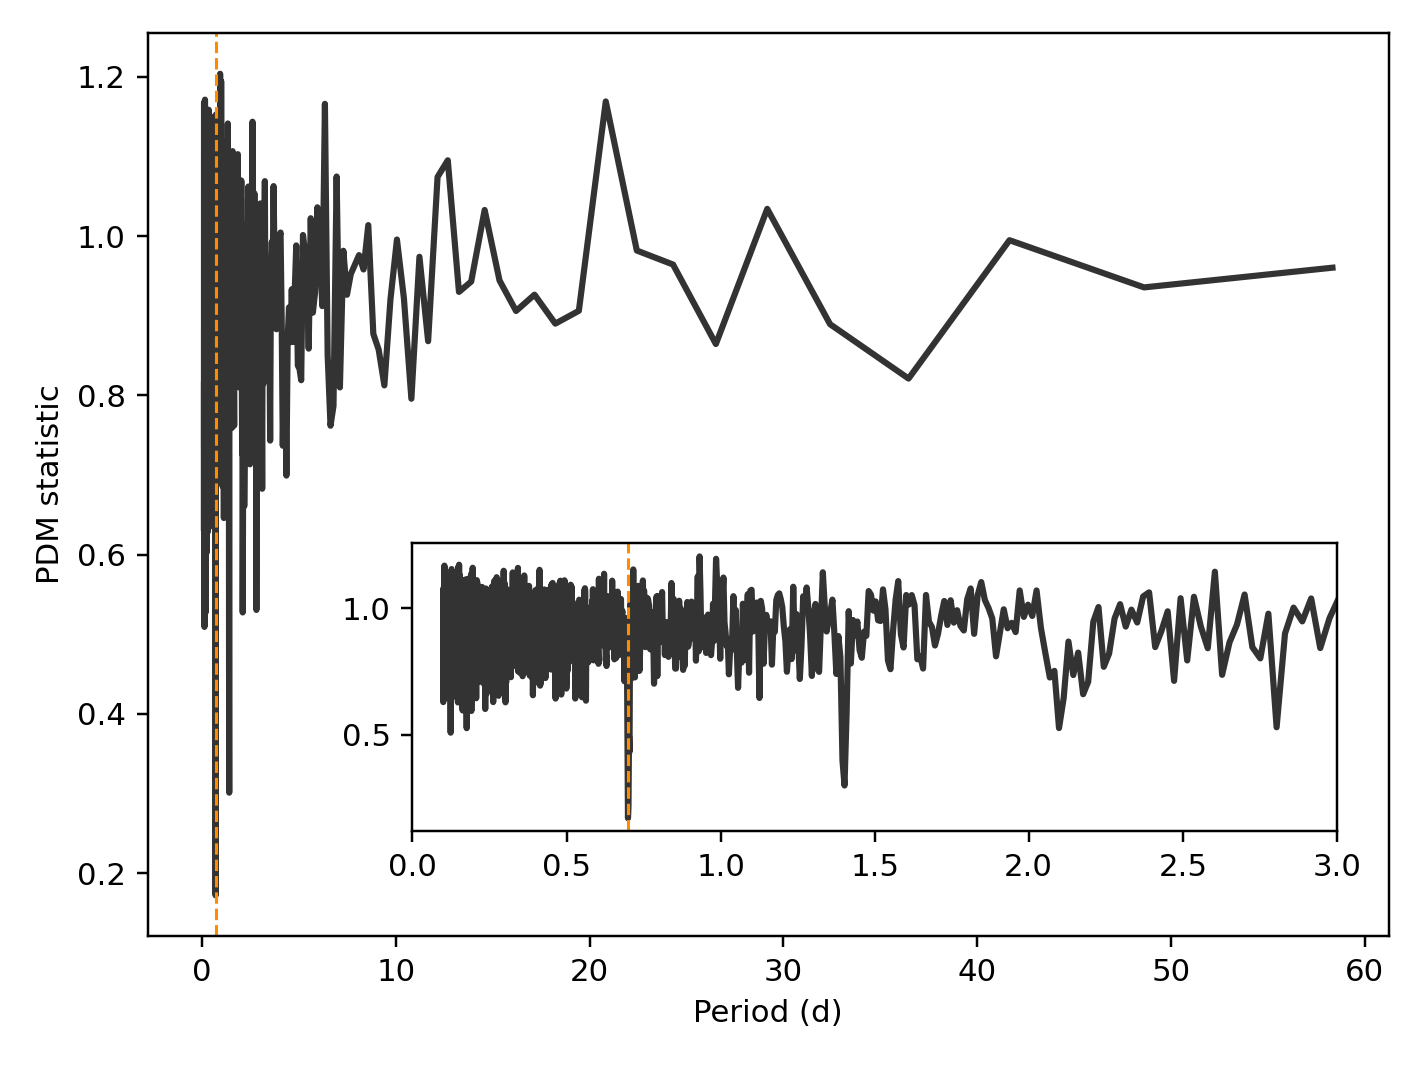

The best-fit period is 0.6994 d


/Users/adamamiller/miniconda3/envs/DSFP/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [10]:
f_grid = np.arange(1/np.ptp(t_obs), 10, 1/5/np.ptp(t_obs))
pdm_psd = pdm_periodogram(t_obs, y, f_grid)

fig, ax = plt.subplots()
ax.plot(1/f_grid, pdm_psd, '0.2', lw=2)
ax.set_xlabel('Period (d)')
ax.set_ylabel('PDM statistic')
ax.axline((0.7,np.mean(pdm_psd)), (0.7, np.mean(pdm_psd)+1e-3), 
          color='DarkOrange',  lw=1, ls='--')


axins = plt.axes([.29, .22, .65, .27])
axins.plot(1/f_grid, pdm_psd, '0.2', lw=2)
axins.axline((0.7,np.mean(pdm_psd)), (0.7, np.mean(pdm_psd)+1e-3), 
          color='DarkOrange',  lw=1, ls='--')
axins.set_xlim(0,3)
fig.tight_layout()

print(f'The best-fit period is {1/f_grid[np.argmin(pdm_psd)]:.4f} d')

## Problem 4) Analysis of Variance

Analysis of Variance (AOV; [Schwarzenberg-Czerny 1989](http://adsabs.harvard.edu/abs/1989MNRAS.241..153S)) is similar to PDM. Optimal periods are defined via hypothesis testing, and these methods are found to perform best for certain types of astronomical signals.

## Problem 5) Supersmoother

Supersmoother ([Reimann](http://adsabs.harvard.edu/abs/1994PhDT........20R)) is a least-squares approach wherein a flexible, non-parametric model is fit to the folded observations at many trial frequncies. The use of this flexible model reduces aliasing issues relative to models that assume a sinusoidal shape, however, this comes at the cost of requiring considerable computational time. 

Briefly, supersmoother provides a smooth estimate of the data via localized linear regression. Observations are then compared to the smooth model value to identify the model that optimally reduces the sum of the square of the residuals. 

This approach requires the use of some adopted span, essentially the region over which the linear fit is performed. The "magic" in supersmoother is that it uses cross-validation to identify the optimal span at every location within the data set.

The psuedo-code procedure is:
  1. create 3 smooth local linear estimations of value of x with span = 0.05, 0.2, and 0.5
  2. identify best span at every position, x, based on residuals
  3. smooth the best span curve from (2) with span = 0.2
  4. create a "final" smooth estimate by interpolating bewtween two smooth curves closest in value to (3)

<IPython.core.display.Javascript object>


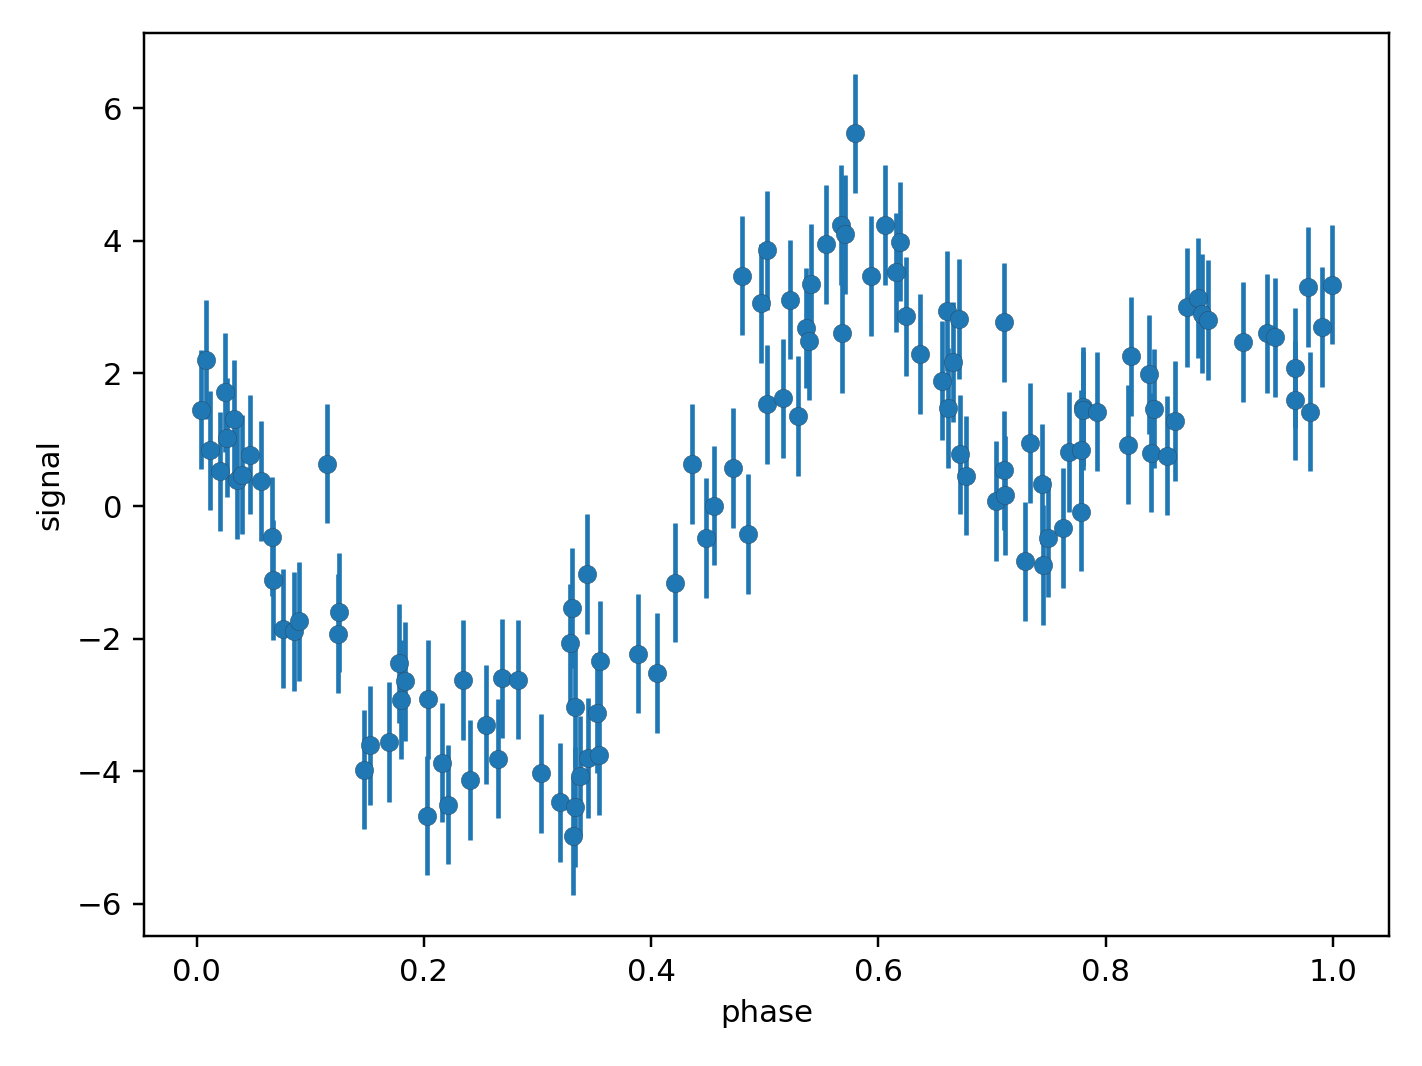

In [19]:
np.random.seed(185)
t_obs = np.random.uniform(60, size=120)
phi = np.pi
var_y = 0.81
y = gen_periodic_data(t_obs, period=0.7, amplitude=3, phase=phi, noise=var_y) 
y += gen_periodic_data(t_obs, period=0.7/2, amplitude=2, phase=phi+np.pi/2)
y += gen_periodic_data(t_obs, period=0.7/3, amplitude=1, phase=phi)
y_unc = np.ones_like(y)*np.sqrt(var_y)
phase_plot(t_obs, y, 0.7, y_unc)

**Problem 5a**

Write a function `smooth` that estimates the value of `y` at every phase `phase` via a linear least squares fit to all the observations within $\pm$`span`/2 of `phase`. The observed value of `y` at phase `phase` should be excluded from the fit. 

*Hint* - it may be helpful to input `x` and `f` so the phase can be calculated within the function.

In [59]:
def smooth(y, x, f, span=0.05, y_unc=None):
    '''Calculate the smooth
    
    Parameters
    ----------
    x : array-like
        input time of observations
    
    y : array-like
        measured signal at input x
    
    f : float 
        frequency for which to calculate the smooth
        
    Returns
    -------
    smooth : array_like
        smooth estimate of the phase folded frequency
    '''
    
    if type(y_unc) == int:
        y_unc = np.ones_like(y)*y_unc
        
    phases = (x*f) % 1
    smooth = np.empty_like(x)
    for obs_num, phase in enumerate(phases):
        this_fit = np.where((phases >= phase - span/2) & 
                            (phases < phase + span/2) & 
                            (phases != phase) & 
                            # Kludge for numerical stability
                            (len(np.where((phases >= phase - span/2) & 
                                          (phases < phase))[0]) > 0
                            ) & 
                            # ask about this during Q&A
                            (len(np.where((phases < phase + span/2) & 
                                          (phases > phase))[0]) > 0
                            )
                           )
        # catch instances where there is not enough data to fit a line
        if len(this_fit[0]) > 1:
            if y_unc is not None:
                lin_fit = np.poly1d(np.polyfit(phases[this_fit],
                                               y[this_fit],
                                               1, 
                                               w = 1/y_unc[this_fit]))
            else:
                lin_fit = np.poly1d(np.polyfit(phases[this_fit],
                                               y[this_fit],
                                               1))
            smooth[obs_num] = lin_fit(phase)
        else:
            smooth[obs_num] = -np.inf

        
    # use linear interpolation to fill in missing smooth
    missing_smooth = np.isinf(smooth)
    smooth[missing_smooth] = np.interp(phases[missing_smooth], 
                                       np.sort(phases[~missing_smooth]), 
                                       smooth[~missing_smooth][np.argsort(phases[~missing_smooth])])

        
    return smooth

**Problem 5b**

Plot the smooth representation of the data with spans of 0.05, 0.2, and 0.5 folded at a period of 0.7 d. 

<IPython.core.display.Javascript object>


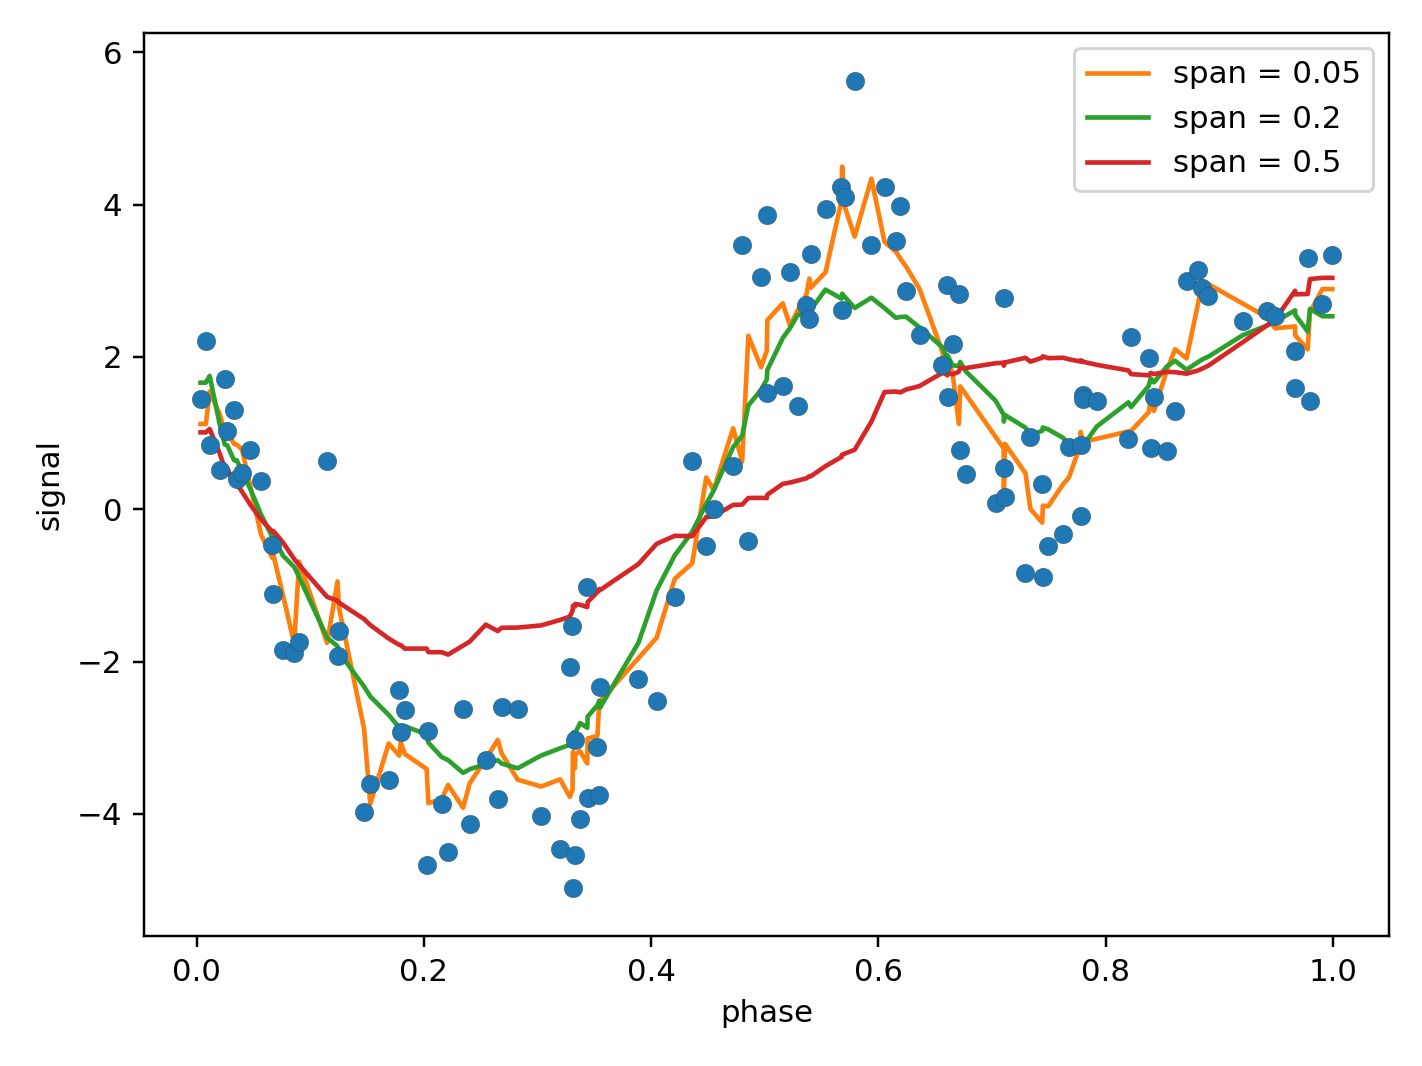

In [74]:
y_unc = 0.1*np.ones_like(y)
phases = (t_obs/0.7) % 1

smooth_tweeter = smooth(y, t_obs, 1/0.7, span=0.05, y_unc=y_unc)
smooth_midrange = smooth(y, t_obs, 1/0.7, span=0.2, y_unc=y_unc)
smooth_woofer = smooth(y, t_obs, 1/0.7, span=0.5, y_unc=y_unc)

phase_plot(t_obs, y, 0.7, y_unc = 0.1*np.ones_like(y))
plt.plot(np.sort(phases), smooth_tweeter[np.argsort(phases)], 
       label="span = 0.05")
plt.plot(np.sort(phases), smooth_midrange[np.argsort(phases)], 
       label="span = 0.2")
plt.plot(np.sort(phases), smooth_woofer[np.argsort(phases)], 
       label="span = 0.5")
plt.legend()

**Probem 5c**

Identify the best span at every phase via the residuals. 

In [75]:
smooth_list = np.vstack([[smooth_tweeter], 
                         [smooth_midrange],
                         [smooth_woofer]])
span_list = np.vstack([[np.ones_like(smooth_tweeter)*0.05], 
               [np.ones_like(smooth_midrange)*0.2],
               [np.ones_like(smooth_woofer)*0.5]])
resid = np.abs(y - smooth_list)

In [76]:
span_midrange = smooth(span_list[np.argmin(resid, axis=0), 0], t_obs, 1/0.7, span=0.2)

<IPython.core.display.Javascript object>


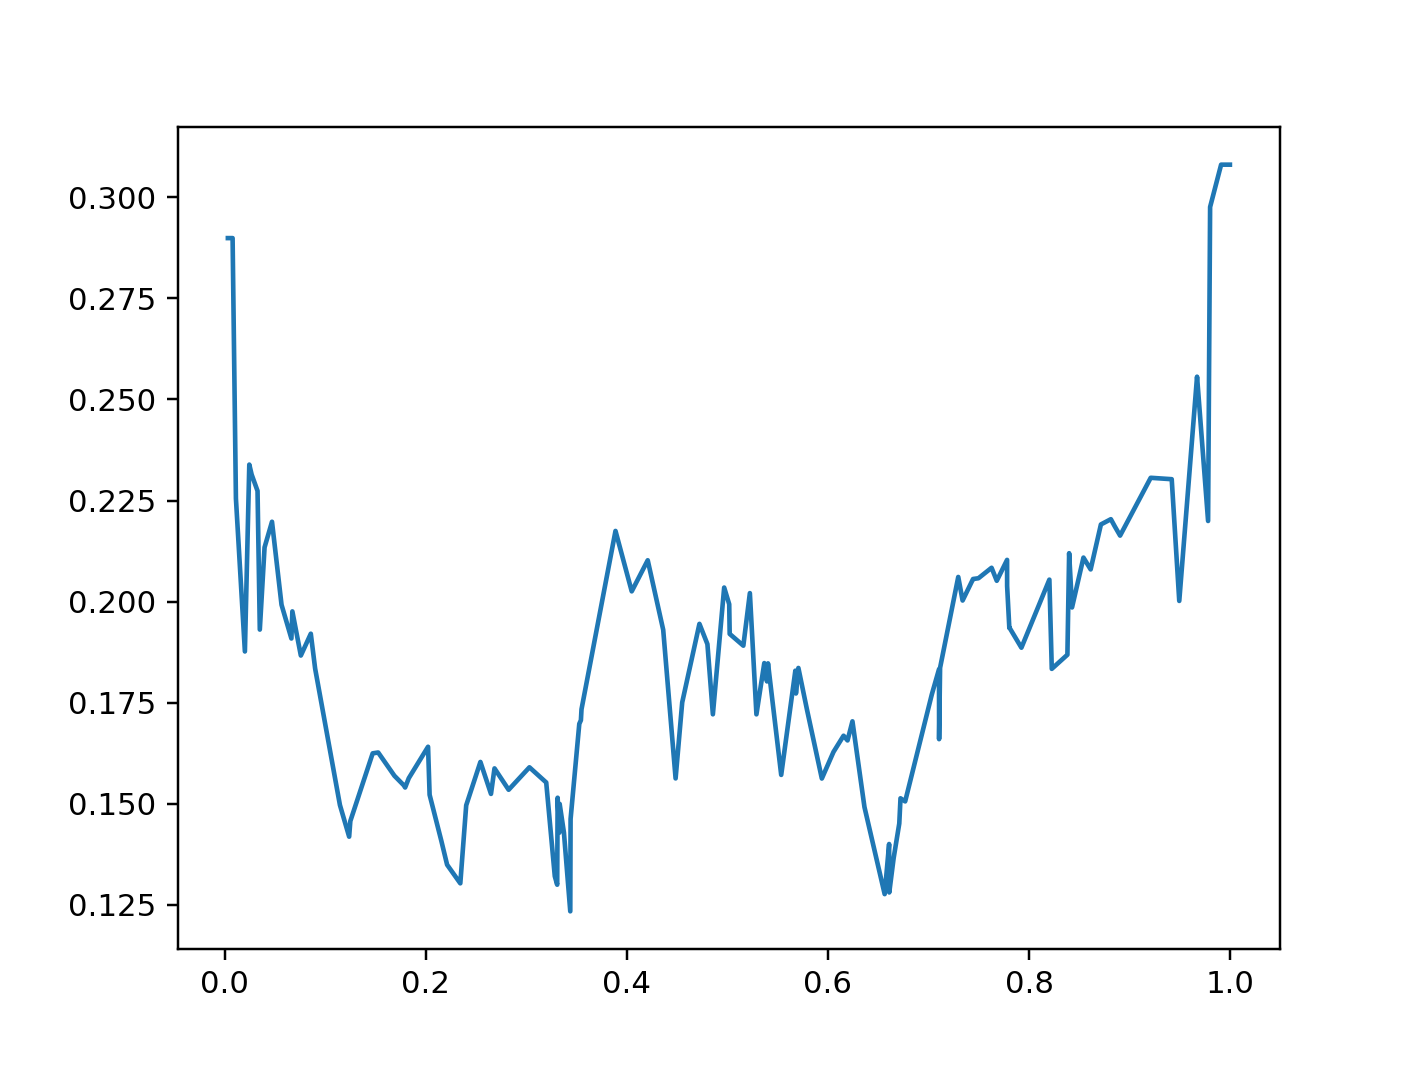

In [77]:
plt.figure()
plt.plot(np.sort(phases), span_midrange[np.argsort(phases)])

In [78]:
supersmooth = np.empty_like(smooth_midrange)
for sm_num, sm in enumerate(span_midrange):
    supersmooth[sm_num] = np.interp(sm, 
                                    span_list.T[sm_num], 
                                    smooth_list.T[sm_num])

<IPython.core.display.Javascript object>


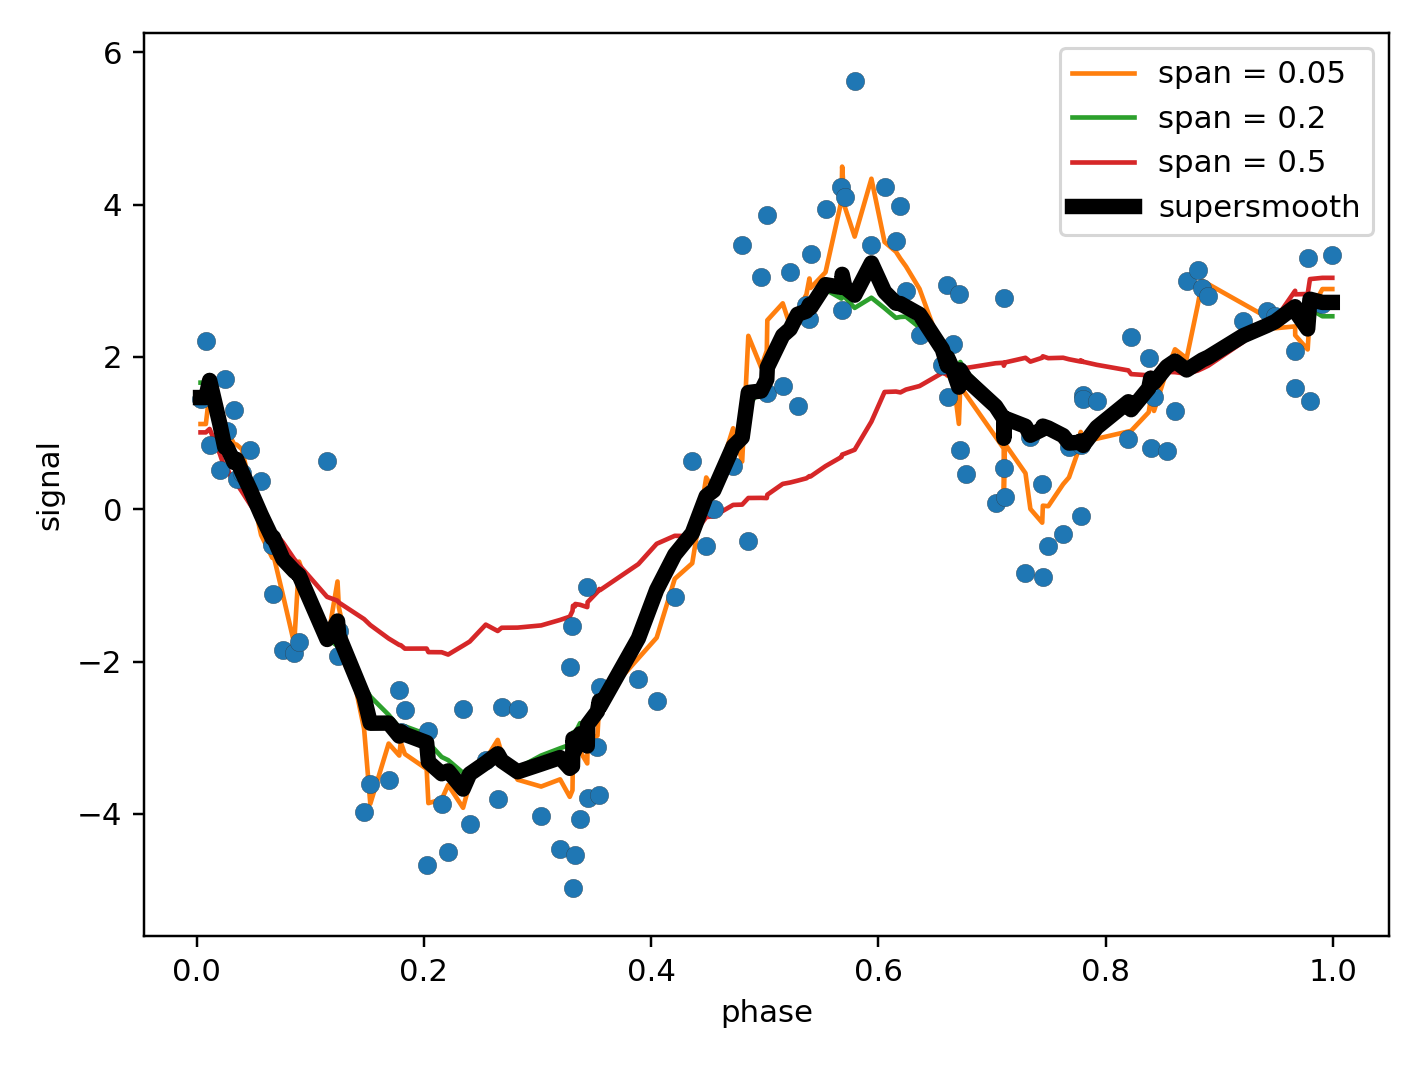

In [79]:
y_unc = 0.1*np.ones_like(y)
phases = (t_obs/0.7) % 1

smooth_tweeter = smooth(y, t_obs, 1/0.7, span=0.05, y_unc=y_unc)
smooth_midrange = smooth(y, t_obs, 1/0.7, span=0.2, y_unc=y_unc)
smooth_woofer = smooth(y, t_obs, 1/0.7, span=0.5, y_unc=y_unc)

phase_plot(t_obs, y, 0.7, y_unc = 0.1*np.ones_like(y))
plt.plot(np.sort(phases), smooth_tweeter[np.argsort(phases)], 
       label="span = 0.05")
plt.plot(np.sort(phases), smooth_midrange[np.argsort(phases)], 
       label="span = 0.2")
plt.plot(np.sort(phases), smooth_woofer[np.argsort(phases)], 
       label="span = 0.5")
plt.plot(np.sort(phases), supersmooth[np.argsort(phases)], lw=5,
         color='k', zorder=10, 
         label='supersmooth')
plt.legend()

In [100]:
def calc_supersmooth(y, x, f, spans=[0.05, 0.2, 0.5], y_unc=None):
    #TODO - accept list of spans as argument
    phases = (x*f) % 1

    smooth_list = np.vstack([[smooth(y, t_obs, f, span=s, y_unc=y_unc) for s in spans]])
    span_list = np.ones_like(s_list)*np.array(spans)[:,None]
    
    resid = np.abs(y - smooth_list)
    
    span_midrange = smooth(span_list[np.argmin(resid, axis=0), 0], 
                           x, f, span=np.median(spans))
    
    supersmooth = np.empty_like(smooth_midrange)
    for sm_num, sm in enumerate(span_midrange):
        supersmooth[sm_num] = np.interp(sm, 
                                        span_list.T[sm_num], 
                                        smooth_list.T[sm_num])
    
    return supersmooth

In [101]:
def supersmooth_periodogram(y, y_unc, x, f_grid):
    psd = np.empty_like(f_grid)
    chi2_0 = np.sum(((y - np.mean(y))/y_unc)**2)
    
    for f_num, f in enumerate(f_grid):
        supersmooth = calc_supersmooth(y, x, f, y_unc=y_unc)
        chi2 = np.sum((y - supersmooth)**2/y_unc**2)
        psd[f_num] = 0.5*(chi2_0 - chi2)
    
    return psd

<IPython.core.display.Javascript object>


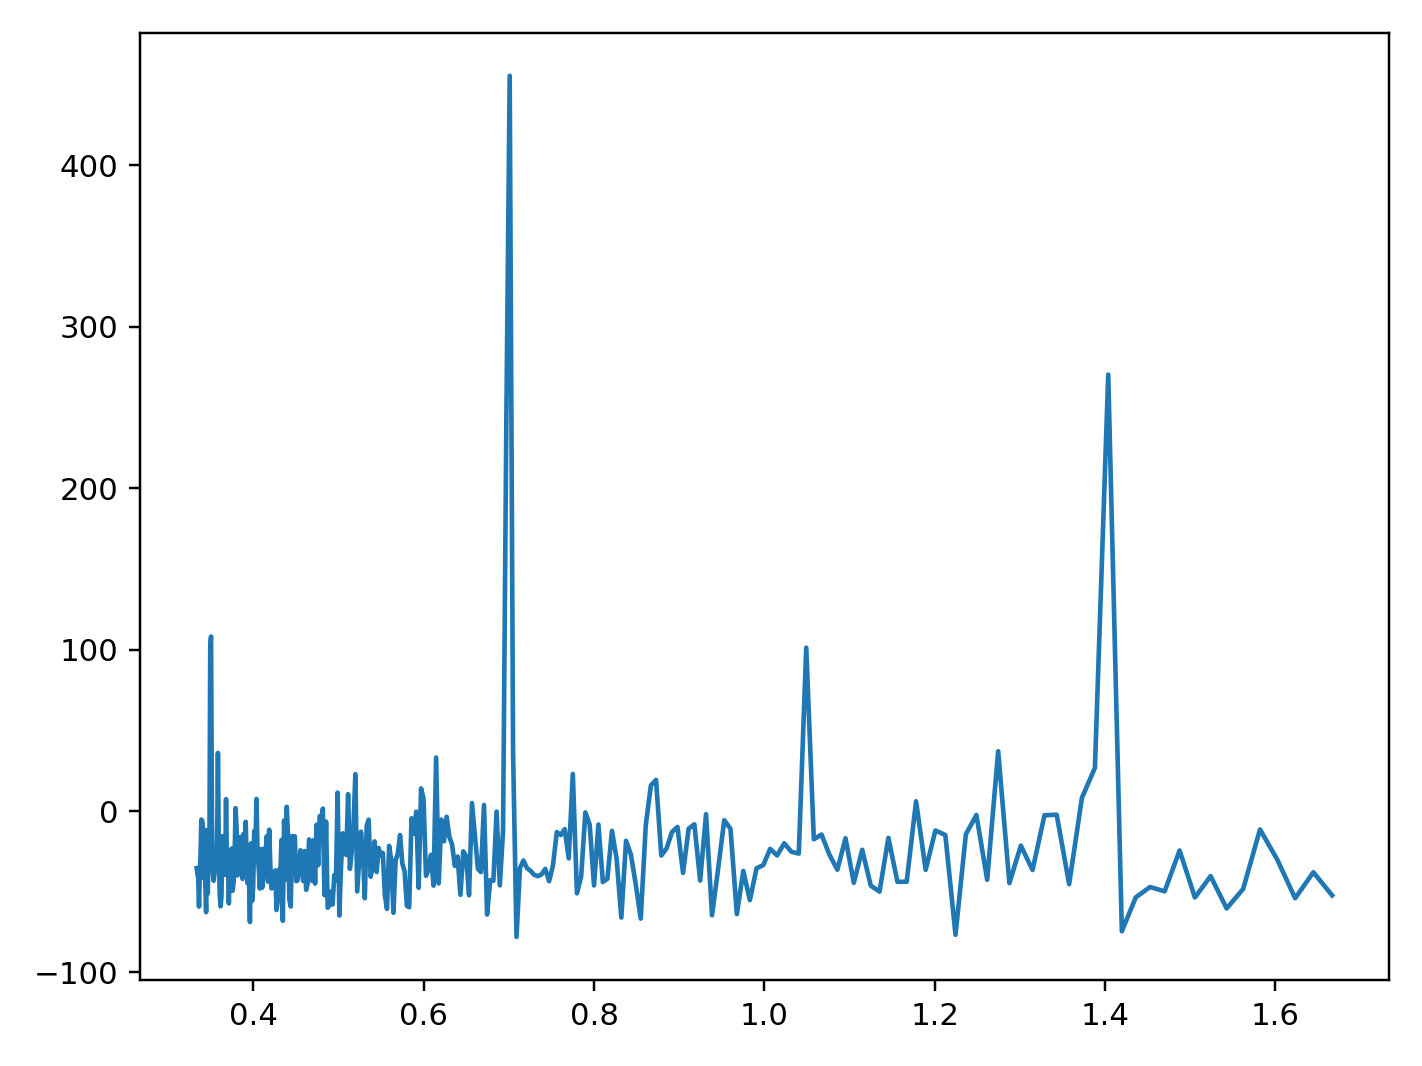

In [109]:
f_grid = np.linspace(0.6, 3, 300)

ss_psd = supersmooth_periodogram(y, y_unc*8.1, t_obs, f_grid)

plt.figure()
plt.plot(1/f_grid, ss_psd)
plt.tight_layout()

Fortunately, Jake VanderPlas has created a python implementation [SuperSmoother](https://www.astroml.org/gatspy/periodic/supersmoother.html) if you are interested in implementing this method. 

## Problem 6) Bayesian Methods

There have been some efforts to frame the period-finding problem in a Bayesian framework. [Bretthorst 1988](https://www.springer.com/us/book/9780387968711) developed Bayesian generalized LS models, while [Gregory & Loredo 1992](http://adsabs.harvard.edu/abs/1992ApJ...398..146G) applied Bayesian techniques to phase-binned models. 

More recently, efforts to use Gaussian processes (GPs) to model and extract a period from the light curve have been developed ([Wang et al. 2012](http://adsabs.harvard.edu/abs/2012ApJ...756...67W)). These methods have proved to be especially useful for detecting stellar rotation in Kepler light curves ([Angus et al. 2018](http://adsabs.harvard.edu/abs/2018MNRAS.474.2094A)). 
